In [1]:
#import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns

In [2]:
dateparser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dataset = pd.read_csv('C:/Faculta anul 3 sem 2/Licenta/DJIA/MMM.csv', sep=',', index_col = 'Date', parse_dates = ['Date'], date_parser = dateparser).fillna(0)
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,237.070007,232.809998,235.779999,235.639999,2931000.0,212.346481
2018-01-03,235.729996,233.289993,235.070007,235.630005,2193700.0,212.337463
2018-01-04,239.440002,236.470001,237.000000,238.710007,2243100.0,215.113022
2018-01-05,240.899994,237.740005,238.649994,240.570007,1835900.0,216.789154
2018-01-08,240.940002,239.179993,239.380005,239.789993,1869000.0,216.086212


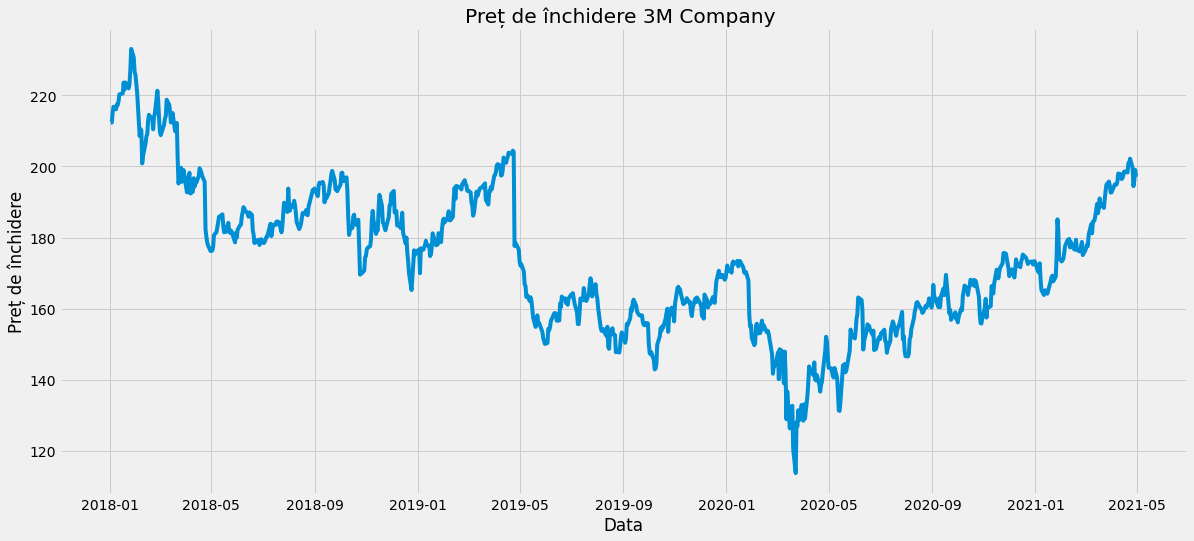

In [3]:
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(dataset['Adj Close'])
plt.title('Preț de închidere 3M Company ')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

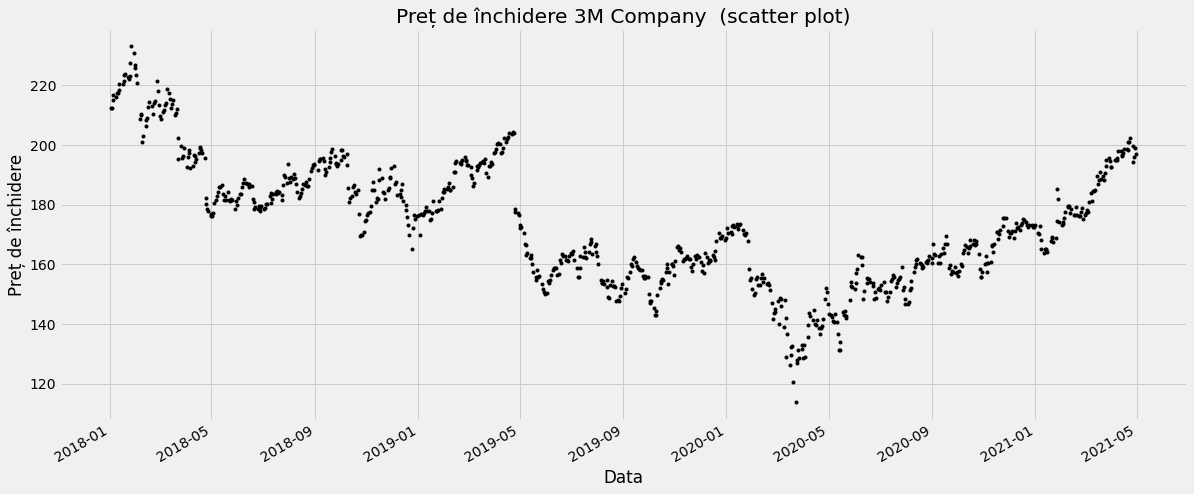

In [4]:
df_close = dataset['Adj Close']
df_close.plot(style='k.')
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.title('Preț de închidere 3M Company  (scatter plot)')
plt.show

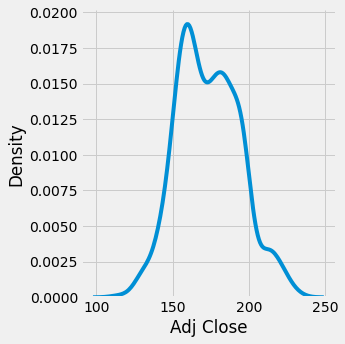

In [5]:
density = sns.displot(dataset, x="Adj Close", kind="kde")

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


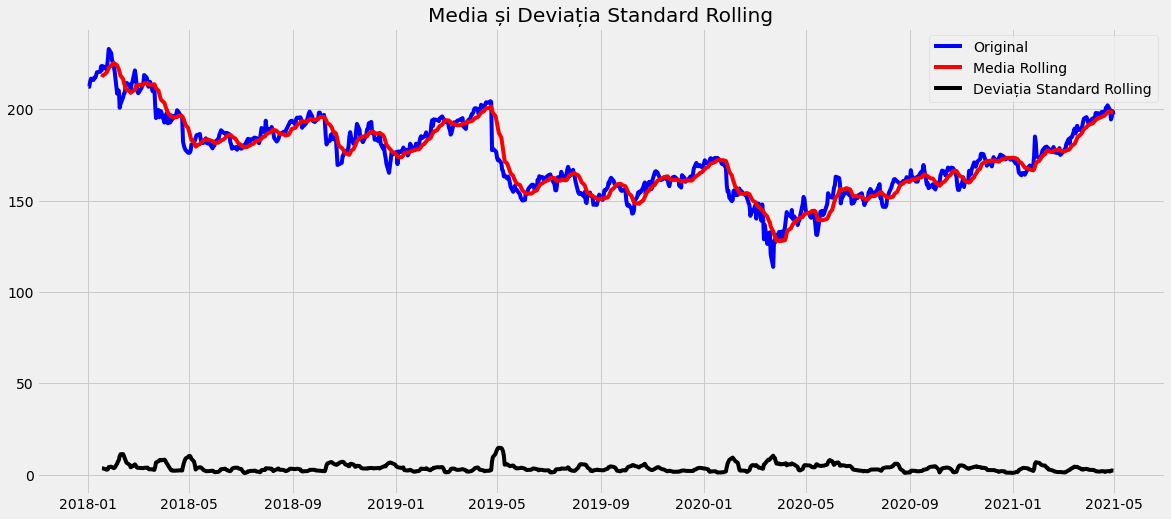

Rezultatele testului Dickey-Fuller Augmentat: 
Test statistic            -2.476751
p-value                    0.121234
Nr. decalaje folosite     11.000000
Nr. observatii           826.000000
valoare critica (1%)      -3.438292
valoare critica (5%)      -2.865045
valoare critica (10%)     -2.568637
dtype: float64


In [6]:
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(12).mean()
    rolling_std = timeseries.rolling(12).std()
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label='Media Rolling')
    plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
    plt.legend(loc='best')
    plt.title('Media și Deviația Standard Rolling')
    plt.show(block=False)
    
    print('Rezultatele testului Dickey-Fuller Augmentat: ')
    adft = adfuller(timeseries, autolag = 'AIC')
    results = pd.Series(adft[0:4],index=['Test statistic','p-value','Nr. decalaje folosite','Nr. observatii'])
    for key, value in adft[4].items():
        results['valoare critica (%s)' %key] = value
    print(results)
test_stationarity(df_close)

<Figure size 1296x576 with 0 Axes>

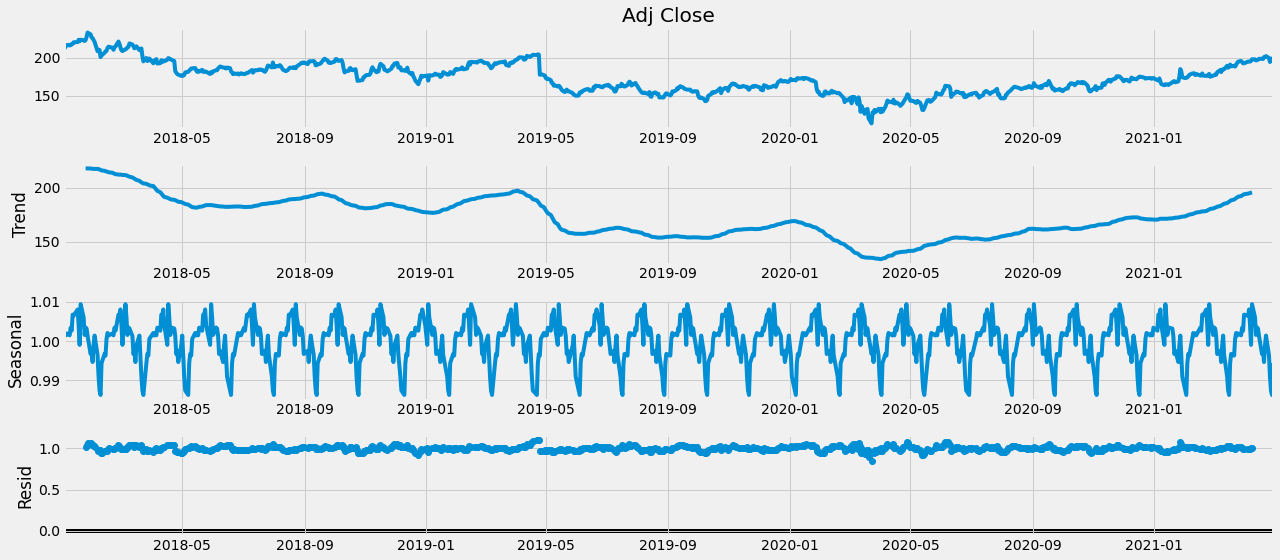

In [7]:
result = seasonal_decompose(df_close, model='multiplicative',freq = 30)
fig = plt.figure()
fig = result.plot()

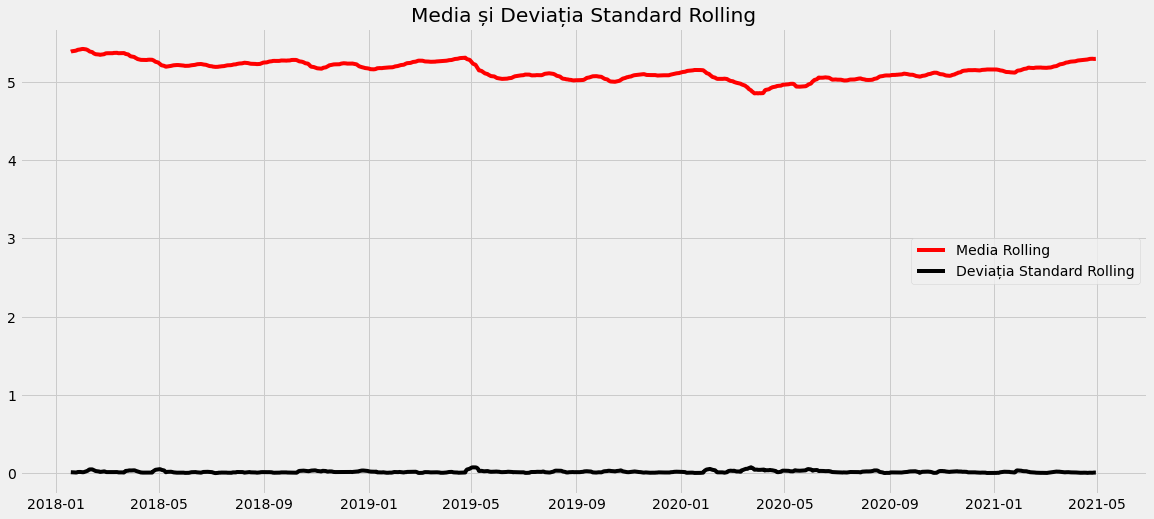

In [8]:
df_log = np.log(df_close)
rolling_mean = df_log.rolling(12).mean()
rolling_std = df_log.rolling(12).std()
plt.title('Media și Deviația Standard Rolling')
plt.plot(rolling_mean, color = 'red', label='Media Rolling')
plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
plt.legend(loc='best')
plt.show()

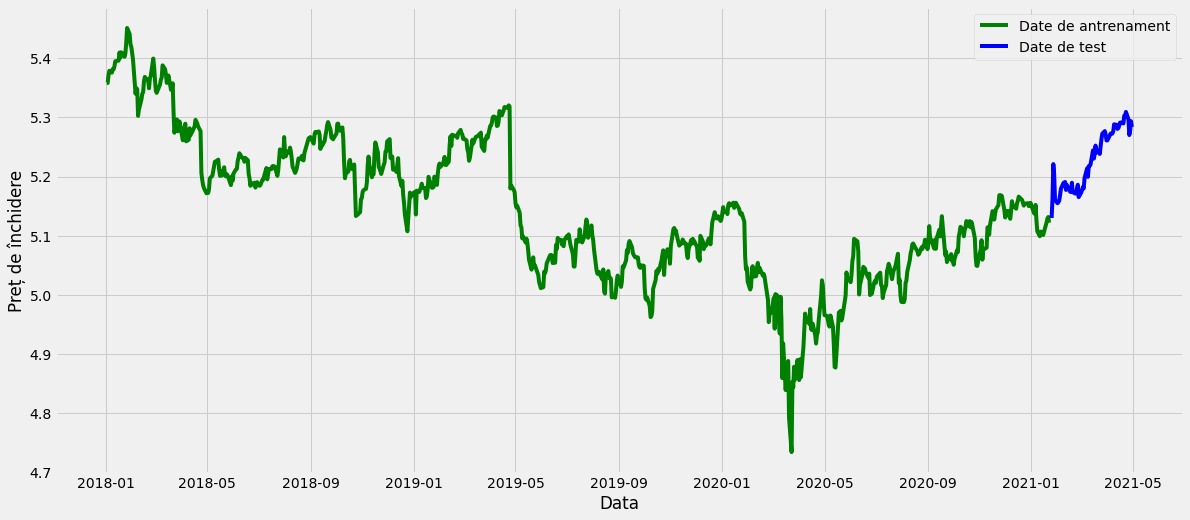

In [9]:
train_data, test_data = df_log[:int(len(df_log)*0.92)], df_log[int(len(df_log)*0.92):]
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(train_data, 'green', label = "Date de antrenament")
plt.plot(test_data, 'blue', label = "Date de test")
plt.legend()

In [17]:
auto_ARIMA = auto_arima(train_data,
                        start_p=0, start_q=0,
                        test = 'adf',
                        max_p=3, max_q=3,
                        m=1,
                        d=2,
                        seasonal=True,
                        start_P=0, 
                        D=0,
                        trace=True,
                        error_action = 'ignore',
                        suppress_warnings=True,
                        stepwise=True,)
print(auto_ARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-3372.843, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-3608.150, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-3696.476, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-3743.564, Time=0.13 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-3741.564, Time=0.17 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.768 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  770
Model:               SARIMAX(3, 2, 0)   Log Likelihood                1875.782
Date:                Mon, 14 Jun 2021   AIC                          -3743.564
Time:                        15:36:30   BIC   

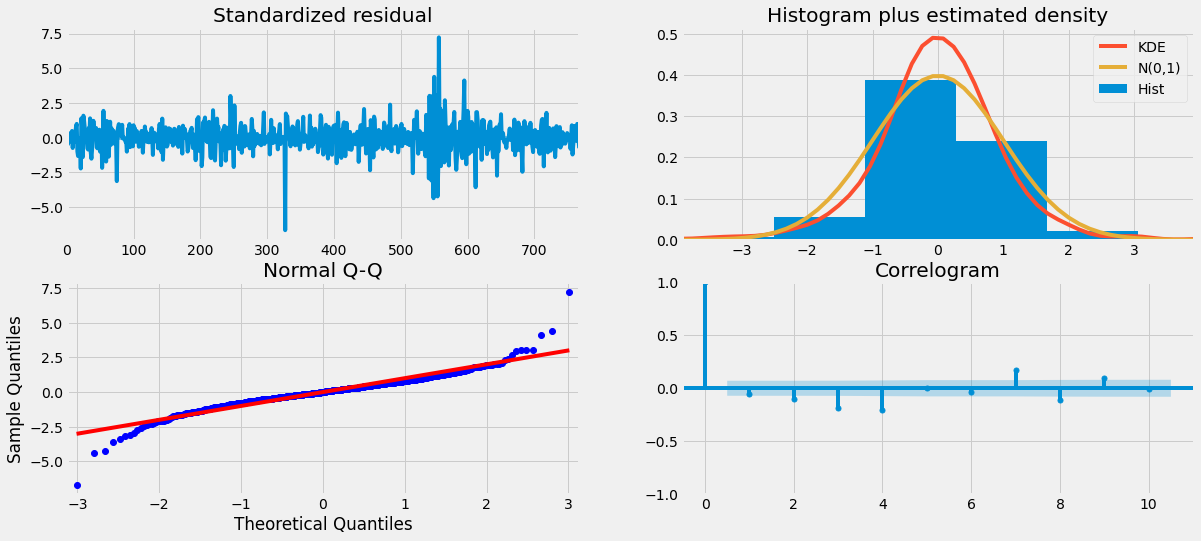

In [11]:
auto_ARIMA.plot_diagnostics()
plt.show()

In [54]:
warnings.filterwarnings('ignore')
model = ARIMA(train_data, order=(3, 2, 0))  
fitted = model.fit(disp=-1,trend=  'nc')  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:           D2.Adj Close   No. Observations:                  768
Model:                 ARIMA(3, 2, 0)   Log Likelihood                1875.782
Method:                       css-mle   S.D. of innovations              0.021
Date:                Sun, 20 Jun 2021   AIC                          -3743.565
Time:                        14:32:36   BIC                          -3724.990
Sample:                             2   HQIC                         -3736.415
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ar.L1.D2.Adj Close    -0.7705      0.035    -22.047      0.000      -0.839      -0.702
ar.L2.D2.Adj Close    -0.5042      0.041    -12.368      0.000      -0.584      -0.424
ar.L3.D2.Adj Close  

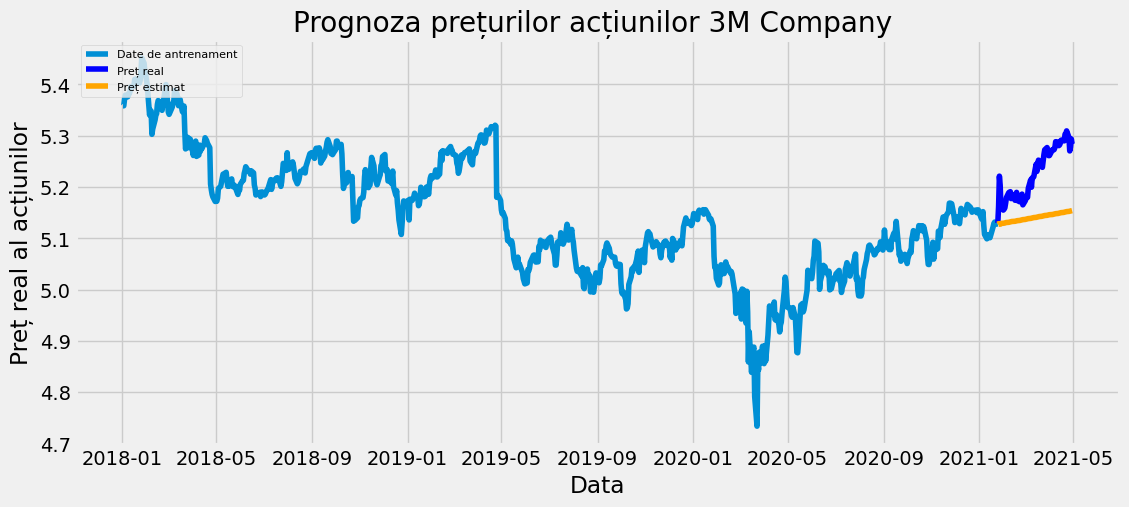

In [55]:
fc, se, conf = fitted.forecast(68, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Date de antrenament')
plt.plot(test_data, color = 'blue', label='Preț real')
plt.plot(fc_series, color = 'orange',label='Preț estimat')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Prognoza prețurilor acțiunilor 3M Company ')
plt.xlabel('Data')
plt.ylabel('Preț real al acțiunilor')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [57]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))*100
print('MAPE: '+str(mape))

MSE: 311.6846450480399
MAE: 15.720822616251155
RMSE: 17.654592746592595
MAPE: 8.234578031292319
